# Diamond Dozen or Dime in Dozen?


## Diamond Price Regressor 

This Jupyter notebook takes qualitative and quantitative features for a compiled set of diamonds to construct regressor models to predict price. 

## Dataset

https://www.kaggle.com/shivam2503/diamonds

## Motivation

Is this diamond just a dime in dozen?$^{1}$ 

Suppose you are the owner of a jewellery store that offers a service to buy diamonds from customers for the purpose of resale. The incentive for you is to resell the diamond at a greater price than the purchase price, thus making profit. As you begin studying diamonds to gain an understanding of the product, you notice that seemingly identical diamonds to the untrained eye can actually differ in price drastically! With no easy way for you to learn the intricacies that lead to the exorbitant values of diamonds, you turn your attention to constructing a machine learning model that can help you predict the prices. You manage to obtain a dataset of diamond prices that were sold in your country along with corresponding relevant features. A sufficiently accurate prediction model will inform your strategy when buying and reselling diamonds to maximize profit margins. 

## Objective

Use the diamonds dataset to construct a regression model to predict diamond prices.

$^{1}$ https://www.theidioms.com/a-dime-adozen/#:~:text=something%20very%20common%20and%20not,abundant%2C%20cheap%20and%20very%20common

Import standard data processing and plotting libraries.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

DATA_PATH = "/Users/jeffguo/PycharmProjects/DiamondsPriceRegression/diamonds.csv"
diamonds_data = pd.read_csv(DATA_PATH)

In [2]:
diamonds_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


The dataset contains qualitative and quantitative features. It also looks like it is sorted in ascending order based on price. Therefore, the dataset should be shuffled when splitting into train/test sets.

In [3]:
diamonds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


The important observation here is that every feature contains 53,940 entries and therefore, there are no missing data points in the dataset. Other observations include the datatypes that comprise the dataset (ex. float64). Notably, "object" can represent any Python object but because the dataset was loaded using pandas' read_csv method, "object" must be text. We confirm this by referring to the cell block above (ex. feature "cut" values include "Ideal", Premium", etc.).

Let's drop the "Unnamed" column as it only provides the index to the dataset.

In [4]:
diamonds_data = diamonds_data.drop("Unnamed: 0", axis=1)

Let's next compute basic statistics of the dataset.

In [5]:
diamonds_data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Let's next observe how each feature affects the price of diamonds.

In [6]:
correlations = diamonds_data.corr()
correlations["price"].sort_values(ascending=False)

price    1.000000
carat    0.921591
x        0.884435
y        0.865421
z        0.861249
table    0.127134
depth   -0.010647
Name: price, dtype: float64

It looks like most features do correlate with the price of diamonds. The notable exception is "depth" which has a negligble correlation (~1%). Therefore, we will exclude "depth" in the input features for the regression model.

Let's remove feature, "depth".

In [7]:
# remove the feature, "depth"
diamonds_data = diamonds_data.drop("depth", axis=1)

Let's next plot histograms to observe the input features distributions.

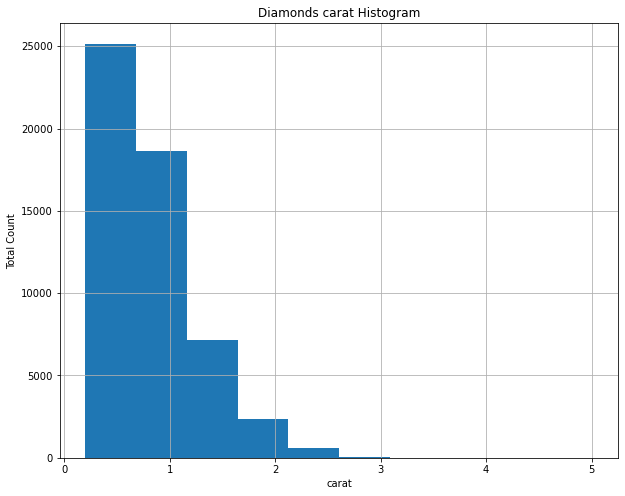

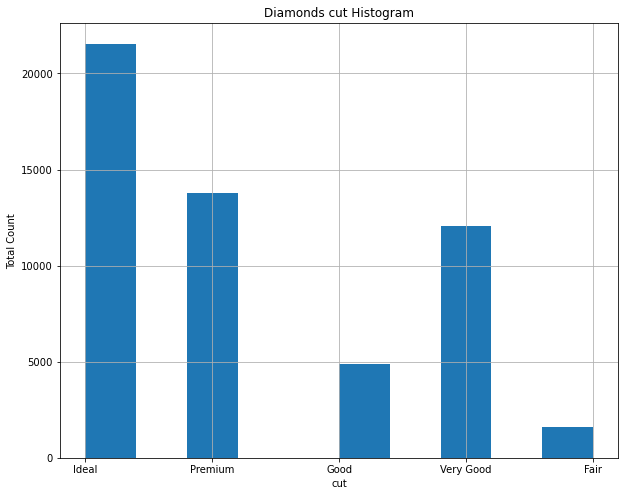

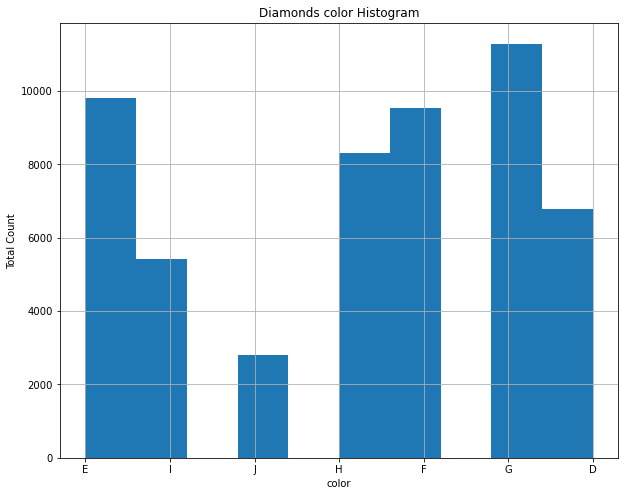

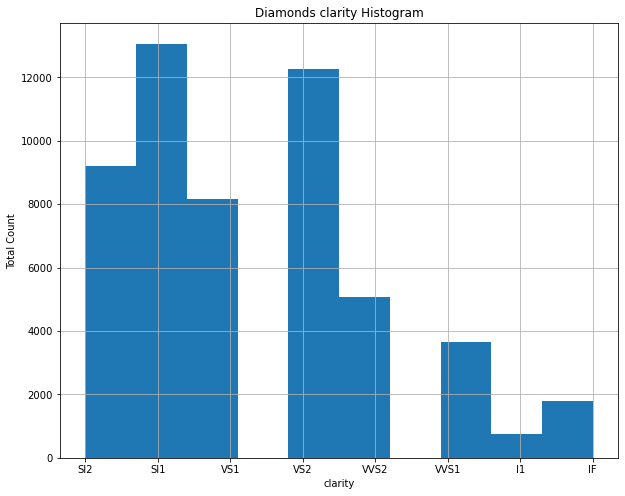

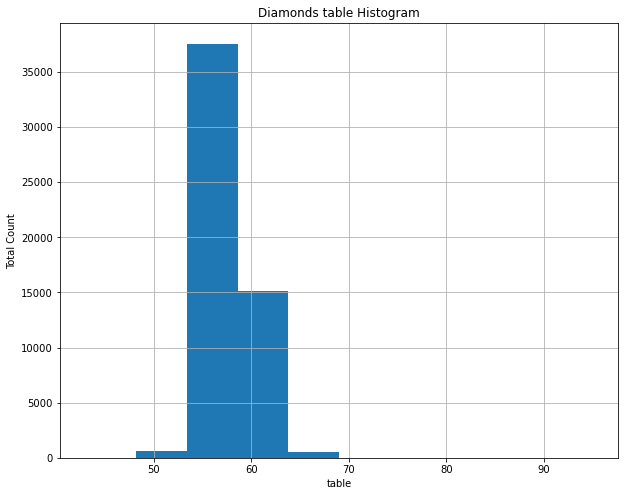

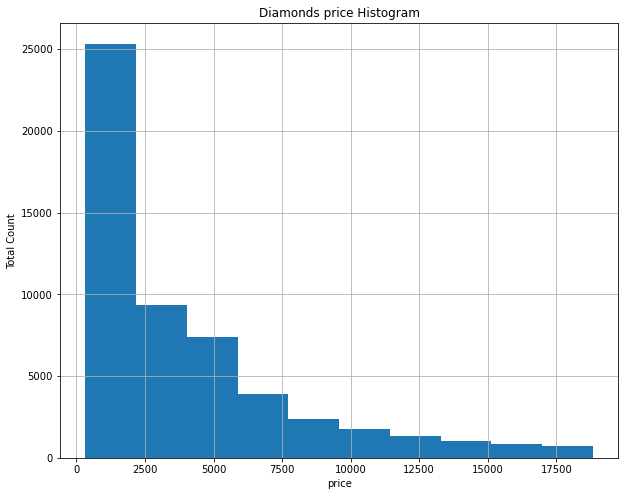

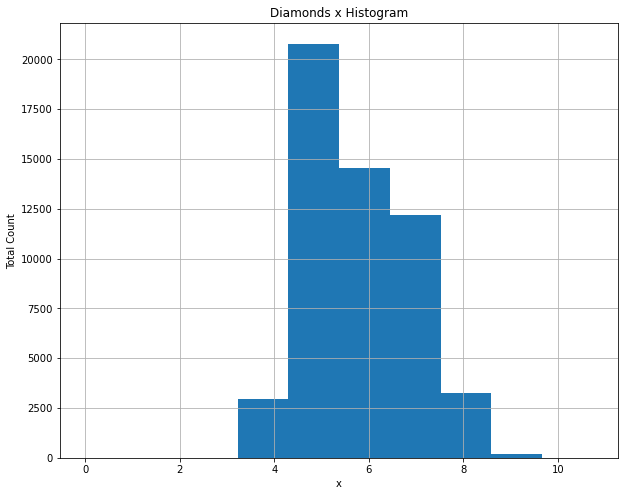

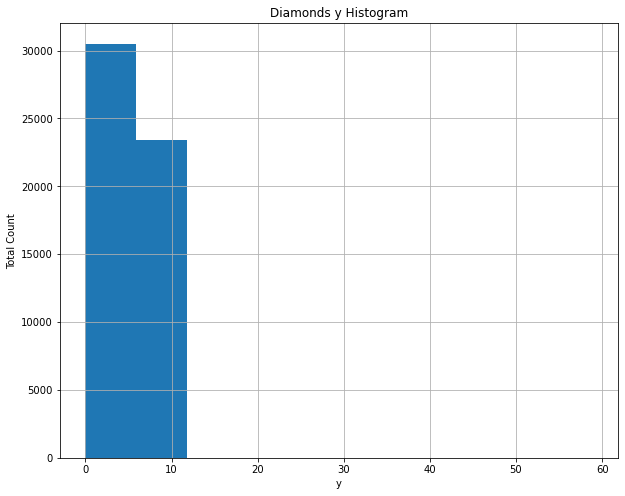

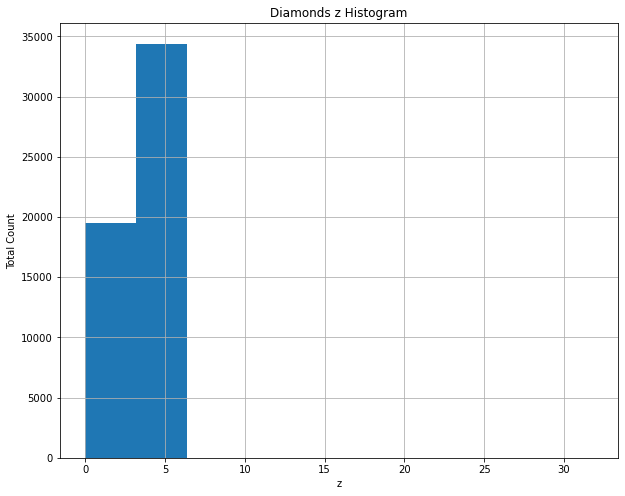

<Figure size 720x576 with 0 Axes>

In [8]:
feature_names = diamonds_data.columns.values

plt.rcParams['figure.figsize'] = [10, 8]

for name in feature_names:
    diamonds_data[name].hist(bins=10)
    plt.title(f"Diamonds {name} Histogram")
    plt.xlabel(name)
    plt.ylabel("Total Count")
    plt.figure()

An important obsevation is that the distribution of some quantitative features (ex. "carat") and the target feature ("price") are heavily "right-skewed". Let's take a closer look at the skewed "price" distribution by creating custom bins.

Categorized Price Strata Value Counts:
1    27542
2    11684
3     6332
4     3160
5     2108
6     1459
7     1162
8      493
Name: price_cat, dtype: int64


Text(0, 0.5, 'Total Count')

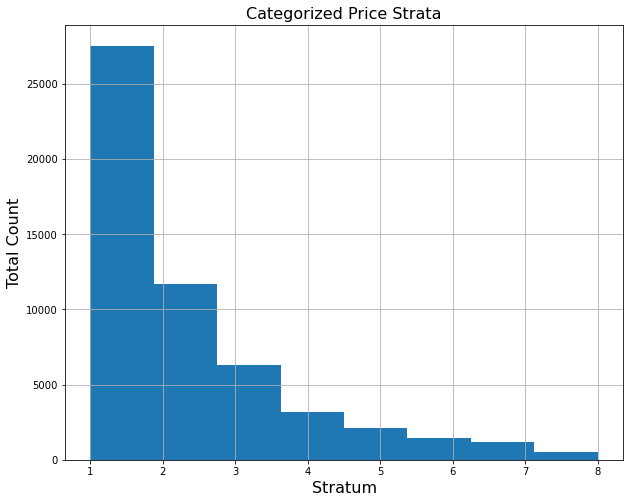

In [9]:
diamonds_data["price_cat"] = pd.cut(diamonds_data["price"],
                                    bins=[0., 2500, 5000, 7500, 10000, 12500, 15000, 17500, np.inf],
                                    labels=[1, 2, 3, 4, 5, 6, 7, 8])

print(f"Categorized Price Strata Value Counts:\n{diamonds_data.price_cat.value_counts()}")

diamonds_data["price_cat"].hist(bins=8)
plt.title("Categorized Price Strata", fontsize=16)
plt.xlabel("Stratum", fontsize=16)
plt.ylabel("Total Count", fontsize=16)

The heavy "right-skew" is evident from the value counts printed and the histogram. When splitting the dataset, care should be given to incorporating the data points from the scarce strata (ex. bin 8 where price > 17,500) to mitigate sampling bias. 

Let's split the dataset into 60/20/20 train/validation/test sets using stratified splitting based on "price_cat".

In [10]:
from sklearn.model_selection import train_test_split

# extract the input features to X
X = diamonds_data.drop("price", axis=1)
# extract the target feature to y
y = diamonds_data["price"]

# perform stratified splitting based on the "price_cat" strata
# random_state=42 for reproducibiility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,
                                                    stratify=diamonds_data["price_cat"], random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True,
                                                  stratify=X_train["price_cat"], random_state=42)

# drop the feature, "price_cat" from the feature DataFrame
for df in (X_train, X_val, X_test):
    df.drop("price_cat", axis=1, inplace=True)

# verify the splitting ratios are as expected
print(f"Training set proportion: {len(X_train)/53940}")
print(f"Validation set proportion: {len(X_val)/53940}")
print(f"Test set proportion: {len(X_test)/53940}")

Training set proportion: 0.6
Validation set proportion: 0.2
Test set proportion: 0.2


/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Following the generation of the train/validation/test sets, we need to prepare the train set for model training. The quantitative features should be standardized and the categorical features need to be encoded. An important attribute to keep in mind is that all the categorical features are ordinal variables, implying a ranked relationship. It follows from the dataset description:

* "cut"

"Fair" (Worst) ----- "Good" ----- "Very Good" ----- "Premium" ----- "Ideal" (Best)

* "color"

"J" (Worst) ----- "I" ----- "H" ----- "G" ----- "F" ----- "E" ----- "D" (Best)

* "clarity"

"I1" (Worst) ----- "SI2" ----- "SI1" ----- "VS2" ----- "VS1" ----- "VVS2" ----- "VVS1" ----- "IF" (Best)

Encoding should capture these ranked relationships as defined.

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# define 3 OrdinalEncoders to control the value mappings according to above 
# (otherwise, OrdinalEncoder encodes via alphabetical order which would not capture the ranked relationship properly)
cut_ord_enc = OrdinalEncoder(categories=[["Fair", "Good", "Very Good", "Premium", "Ideal"]])
color_ord_enc = OrdinalEncoder(categories=[["J", "I", "H", "G", "F", "E", "D"]])
clarity_ord_enc = OrdinalEncoder(categories=[["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]])

# extract the numerical input feature names
num_feature_names = list(X_train.drop(["cut", "color", "clarity"], axis=1))
# extract each categorical input feature name separately to use the different OrdinalEncoders defined above
cut_feature_name = ["cut"]
color_feature_name = ["color"]
clarity_feature_name = ["clarity"]

processing_pipeline = ColumnTransformer([
                      ("num", StandardScaler(), num_feature_names),
                      ("cut", cut_ord_enc, cut_feature_name),
                      ("color", color_ord_enc, color_feature_name),
                      ("clarity", clarity_ord_enc, clarity_feature_name)])

X_train_prepped = processing_pipeline.fit_transform(X_train)

It was important during feature processing that standardization does not compute the mean and standard deviation of the entire dataset so as to avoid data leakage. This was avoided as we previously split the data into train/val/test sets where the validation and test sets were untouched. Consequently, standardization was performed using the mean and standard deviation computed from only the train set. When we evaluate our regression models on the validation and test sets, they must be standardized according to the train set mean and standard deviation. 

Let's standardize the validation and test sets now to prospectively prepare them for model evaluation.

In [12]:
# use transform and not fit_transform to maintain the mean and standard deviation of the train set
X_val_prepped = processing_pipeline.transform(X_val)
X_test_prepped = processing_pipeline.transform(X_test)

The validation and test sets are now standardized and encoded.

Following numerical and categorical features standardization and encoding, respectively on the train set, we are now ready for model training. Let's train Linear Regression (LR), Linear Support Vector Machine (SVM) Regressor, Poly SVM Regressor, and Random Forest Regressor models.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# random_state 42 for reproducibility
lin_reg = LinearRegression()
lin_svr = LinearSVR(random_state=42)
poly_svr = SVR(kernel="poly")
rf_reg = RandomForestRegressor(random_state=42)

# fit all the models on the train set
lin_reg.fit(X_train_prepped, y_train)
lin_svr.fit(X_train_prepped, y_train)
poly_svr.fit(X_train_prepped, y_train)
rf_reg.fit(X_train_prepped, y_train)

RandomForestRegressor(random_state=42)

Next, let's evaluate the performances of each model. Firstly, calculate the root-mean-square-error (RMSE) on the train set to gain an understanding of the train accuracy. Secondly, calculate the RMSE on the validation set to gain an understanding of the generalization error.

In [14]:
from sklearn.metrics import mean_squared_error

model_names = ["Linear Regression", "Linear SVR", "Poly SVR", "Random Forest Regressor"]
train_rmse_list = []
val_rmse_list = []
val_gen_error_list = []

for model in (lin_reg, lin_svr, poly_svr, rf_reg):
    # extract the predictions made by each model on the train set
    y_train_pred = model.predict(X_train_prepped)
    # extract the predictions made by each model on the validation set
    y_val_pred = model.predict(X_val_prepped)
    # calculate the rmse for each model on the train set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # calculate the rmse for each model on the validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    # calculate the generalization error on the validation set
    gen_error = f"{round(((val_rmse-train_rmse)/train_rmse*100),2)}%"
    
    # populate the correspoding lists to save the calculated values
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    val_gen_error_list.append(gen_error)
    
# construct a DataFrame to display the rmse values
rmse_df = pd.DataFrame({"Model": model_names,
                        "Train RMSE": train_rmse_list,
                        "Val. RMSE": val_rmse_list,
                        "   Val. Error": val_gen_error_list})

print(rmse_df.to_string(index=False))

                   Model   Train RMSE    Val. RMSE    Val. Error
       Linear Regression  1226.064210  1217.416510        -0.71%
              Linear SVR  1474.828535  1501.940046         1.84%
                Poly SVR  1840.865066  2319.300043        25.99%
 Random Forest Regressor   211.747523   536.207311       153.23%


Key insights:

1) Linear Regression and Linear SVR models generalize well on the validation set

2) Poly SVR is overfitting given the relatively poor generalization error on the validation set

3) Random Forest Regressor seems to perform the best on the train set but is probably heavily overfitting as the model was given total freedom in hyperparameter values --> reinforced by the poor generalization error

The next step will be to tune the hyperparameters of the models to achieve 3 objectives:
1) Reduce overfitting --> particularly relevant to the Poly SVR and Random Forest Regressor

2) Reduce the RMSE

3) Determine which model performs best on the validation set

Note: Standard Linear Regression using Least Squares does not have any hyperparameters. If the model were overfitting, regularization techniques such as Lasso or Ridge Regression could be used. As this is not the case, the Linear Regression model will be kept as is.

In [15]:
from sklearn.model_selection import GridSearchCV

# Linear SVR hyperparameters to try
# try greater "C" values since the current Linear SVR has low generalization error on the validation set
lin_svr_param_grid = [{"C": [5, 10, 15, 20]}]

# Poly SVR hyperparameter combinations to try
# try smaller "C" values since the current Poly SVR has a high generalization error on the validation set
# avoid polynomial degrees > 3 as the Poly SVR is already overfitting (current model is using degree 3)
poly_svr_param_grid = [{"C": [0.25, 0.50, 0.75, 1], 
                        "degree": [2, 3],
                        "coef0": [0.0, 0.25, 0.50, 0.75, 1.0]}]

# Random Forest hyperparameter combinations to try (there are many other hyperparameters that are not tried here)
rf_reg_param_grid = [{"n_estimators": [100, 200, 300, 400, 500],
                      "max_features": [2, 3, 4, 5, 6]}]

lin_svr_gscv = GridSearchCV(lin_svr, param_grid=lin_svr_param_grid, cv=5)
poly_svr_gscv = GridSearchCV(poly_svr, param_grid=poly_svr_param_grid, cv=5)
rf_reg_gscv = GridSearchCV(rf_reg, param_grid=rf_reg_param_grid, cv=5)

# re-train all 3 models with the best hyperparameters found
lin_svr_gscv.fit(X_train_prepped, y_train)
poly_svr_gscv.fit(X_train_prepped, y_train)
rf_reg_gscv.fit(X_train_prepped, y_train)

# display the best hyperparameters from the combinations tried
print(f"Linear SVR Best Hyperparameters Found: {lin_svr_gscv.best_params_}")
print(f"Poly SVR Best Hyperparameters Found: {poly_svr_gscv.best_params_}")
print(f"Random Forest Regressor Best Hyperparameters Found: {rf_reg_gscv.best_params_}")

Linear SVR Best Hyperparameters Found: {'C': 15}
Poly SVR Best Hyperparameters Found: {'C': 1, 'coef0': 1.0, 'degree': 3}
Random Forest Regressor Best Hyperparameters Found: {'max_features': 5, 'n_estimators': 500}


In [16]:
model_names = ["Linear Regression", "Linear SVR", "Poly SVR", "Random Forest Regressor"]
gscv_train_rmse_list = []
gscv_val_rmse_list = []
gscv_val_gen_error_list = []

for model in (lin_reg, lin_svr_gscv, poly_svr_gscv, rf_reg_gscv):
    # extract the predictions made by each model on the train set
    y_train_pred = model.predict(X_train_prepped)
    # extract the predictions made by each model on the validation set
    y_val_pred = model.predict(X_val_prepped)
    # calculate the rmse for each model on the train set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # calculate the rmse for each model on the validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    # calculate the generalization error on the validation set
    gen_error = f"{round(((val_rmse-train_rmse)/train_rmse*100),2)}%"
    
    # populate the correspoding lists to save the calculated values
    gscv_train_rmse_list.append(train_rmse)
    gscv_val_rmse_list.append(val_rmse)
    gscv_val_gen_error_list.append(gen_error)
    
# construct a DataFrame to display the rmse values
rmse_df = pd.DataFrame({"Model": model_names,
                        "Prev. Train RMSE": train_rmse_list,
                        "Train RMSE": gscv_train_rmse_list,
                        "Prev. Val. RMSE": val_rmse_list,
                        "Val. RMSE": gscv_val_rmse_list,
                        "Prev. Val. Error": val_gen_error_list,
                        "   Val. Error": gscv_val_gen_error_list})

print(rmse_df.to_string(index=False))

                   Model  Prev. Train RMSE   Train RMSE  Prev. Val. RMSE    Val. RMSE Prev. Val. Error    Val. Error
       Linear Regression       1226.064210  1226.064210      1217.416510  1217.416510           -0.71%        -0.71%
              Linear SVR       1474.828535  1355.509103      1501.940046  1397.886077            1.84%         3.13%
                Poly SVR       1840.865066   979.123828      2319.300043  1725.270403           25.99%        76.21%
 Random Forest Regressor        211.747523   203.630213       536.207311   532.716693          153.23%       161.61%


The GridSearchCV results are summarized in the output of the above cell block. Firstly, the Linear Regression model was not modified at all as there are no hyperparameters. For the other models, the validation errors seem to have increased! While this is true, it is important to also look at the absolute RMSE differences post-GridSearchCV. Taking a deeper look at the Linear SVR, Poly SVR, and Random Forest Regressor models, both the train and validation RMSE was reduced which is a good sign that GridSearchCV has improved the models. That being said, the validation errors still suggest overfitting, especially in the case of the Poly SVR where the magnitude of the difference between the validation RMSE - train RMSE is quite large. Given these observations, it would be beneficial to try a wider range of hyperparameter values in during GridSearchCV. In particular, there are many hyperparameters that can be tuned for Random Forests. This is not done in this notebook as the relatively large dataset requires extensive training time. 


Finally, given the model performances, it is clear that the Random Forest Regressor performs the best by far. Suppose we are happy with the hyperparameter tuning and wish to evaluate the Random Forest Regressor on the test set. The first thing we need to do is compile the train and validation sets together and retrain the model. A simple way to achieve this is to regenerate the original train/test sets. The below cell block accomplishes this and reuses much of the previous code.

In [17]:
# perform stratified splitting based on the "price_cat" strata
# random_state=42 for reproducibiility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,
                                                    stratify=diamonds_data["price_cat"], random_state=42)

# Following the above step, X_train represents the train + validation set
# Next, apply feature processing as defined by the previously contructed pipeline
X_train_prepped = processing_pipeline.fit_transform(X_train)

An important distinction between the above pipeline transformation we just performed is that the standardization uses the data from both the train and validation sets together. Previously, we only performed standardization on the train set and carried forward the train set mean and standard deviation to the validation set so as to avoid data leakage. We did this so that evaluating the models using the validation set, like above, provides a more reasonable and accurate performance measure. Following Random Forest Regressor hyperparameter tuning, we retrain the model and standardize based on the compiled train and validation sets data.

In [18]:
rf_reg_final = RandomForestRegressor(n_estimators=500, max_features=5, random_state=42)
rf_reg_final.fit(X_train_prepped, y_train)

RandomForestRegressor(max_features=5, n_estimators=500, random_state=42)

Before we can evaluate on the test set, we need to also standardize the test set based on the new mean and standard deviation calculated for the aggregated train + validation sets.

In [19]:
# only use transform instead of fit_transform to use the train + val set mean and standard deviation
# this is to avoid data leakage to the test set
X_test_prepped = processing_pipeline.transform(X_test)

Let's now evaluate the Random Forest Regressor on the test set.

In [20]:
# generate the predicted diamond prices on the test set
y_test_pred = rf_reg_final.predict(X_test_prepped)
# calculate the RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# display the final model hyperparameters and results
print("Random Forest Regressor Post-GSCV")
print(f"Hyperparameter max_features: {5}")
print(f"Hyperparameter n_estimators: {500}")
print(f"Test Set RMSE: {test_rmse}")

Random Forest Regressor Post-GSCV
Hyperparameter max_features: 5
Hyperparameter n_estimators: 500
Test Set RMSE: 533.5745604557677


The test set RMSE is ~ 533.57 which is almost identical to the validation set RMSE (~ 532.72). The validation set used to obtain the validation RMSE was standardized using the training set mean and standard deviation. This minimized data leakage and we observe that the validation set becomes a good tool to get a sense of the generalization error of our model. This is reinforced by the almost identical RMSE obtained on the test set.